<a href="https://colab.research.google.com/github/shivanshus/Machine-Learning-Projects/blob/main/DecisionTree_%26_Bagging_Classifier_for_Server_Load_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Server Load Prediction Model**
---
This project is to develop and train a model for Server Load Prediction. We have a dataset containing details of various aspects of a web server running a variety of different software applications.

The dataset consists of a set of variables that were measured over about a one month period. The data is not sequential and each data point can be considered a snapshot of the server state. Given this snapshot, you need to predict whether the server is on low, medium or high load. Measurements were taken in one minute intervals and on each server. They are usually the average or sum over that one minute interval. For instance, the number of packets received, the average number of IO operations, etc.

### Importing libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score, precision_score, recall_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Importing data

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")

In [63]:
train.head(3)

,m_id,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,io_mailbox_write_rate,io_split_transfer_rate,io_file_open_rate,io_logical_name_trans,io_page_reads,io_page_writes,page_free_list_faults,page_modified_list_faults,page_demand_zero_faults,state_compute,state_mwait,state_lef,state_hib,state_cur,app06_dirio,app06_bufio,app06_pgflts,app06_proccount,app06_pagesgbl,app06_pagesproc,app07_dirio,app07_bufio,app07_pgflts,app07_proccount,app07_pagesgbl,app07_pagesproc,app04_dirio,app04_bufio,app04_pgflts,app04_proccount,app04_pagesgbl,app04_pagesproc,app08_dirio,app08_bufio,app08_pgflts,app08_proccount,app08_pagesgbl,app08_pagesproc,app01_dirio,app01_bufio,app01_pgflts,app01_proccount,app01_pagesgbl,app01_pagesproc,app05_dirio,app05_bufio,app05_pgflts,app05_proccount,app05_pagesgbl,app05_pagesproc,app03_dirio,app03_bufio,app03_pgflts,app03_proccount,app03_pagesgbl,app03_pagesproc,app02_dirio,app02_bufio,app02_pgflts,app02_proccount,app02_pagesgbl,app02_pagesproc,tcp_in,tcp_out,tcp_rxdup,tcp_retxpk,tcp_retxto,tcp_kpalv,lla0_pkts_recvpsec,lla0_pkts_sentpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec,cpu_load
0,c,38.50,458.07,0.00,0.0,259,22,0.4,0.0,170323,60557,0.40,0.0,0.28,317.68,0.0,1.93,0.0,0.00,0.00,6,0,192,39,2,0,0,0,1,17,102,1.6,230.73,0.0,65,14037,31358,0.00,0.00,0.00,0,0,0,0.6,0.3,0.0,8,1084,7936,0.0,0.0,0.0,0,0,0,0.33,188.68,0.0,95,23458,141056,0.0,0.0,0.0,4,178,1538,6.00,18.97,0.0,34,5056,6275,5,5,35,0,0,0,415.483,479.983,15.367,20.667,281.383,245.533,278.767,277.300,medium
1,a,66.43,657.65,0.43,0.0,272,12,23.8,0.4,121776,102325,20.58,0.0,0.73,475.13,0.0,44.13,0.0,0.02,0.02,4,0,212,44,2,0,0,0,1,13,94,1.5,384.48,0.0,62,12880,29729,13.75,0.12,0.43,58,102879,57012,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.20,127.40,0.0,63,13982,87229,0.0,0.0,0.0,4,949,3832,22.57,99.57,0.0,24,4940,5153,4,4,0,0,0,0,526.533,554.550,67.300,88.650,438.583,401.633,436.000,366.183,medium
2,f,29.07,322.25,0.00,0.0,171,10,0.0,0.0,271435,44159,0.03,0.0,0.12,262.97,0.0,0.00,0.0,0.00,0.00,4,0,119,38,2,0,0,0,1,12,70,1.0,185.37,0.0,40,8076,16939,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.53,124.33,0.0,63,14355,88588,0.0,0.0,0.0,4,214,1556,0.00,0.00,0.0,11,1839,1894,5,5,0,0,0,0,337.967,314.067,0.667,0.017,230.333,230.050,220.200,240.333,low


### Exploratory Data Analysis

In [64]:
train['m_id'].value_counts()

b    17172
e    17137
d    17137
f    17099
g    17093
a    17092
c    17052
Name: m_id, dtype: int64

In [65]:
train.describe()

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,io_mailbox_write_rate,io_split_transfer_rate,io_file_open_rate,io_logical_name_trans,io_page_reads,io_page_writes,page_free_list_faults,page_modified_list_faults,page_demand_zero_faults,state_compute,state_mwait,state_lef,state_hib,state_cur,app06_dirio,app06_bufio,app06_pgflts,app06_proccount,app06_pagesgbl,app06_pagesproc,app07_dirio,app07_bufio,app07_pgflts,app07_proccount,app07_pagesgbl,app07_pagesproc,app04_dirio,app04_bufio,app04_pgflts,app04_proccount,app04_pagesgbl,app04_pagesproc,app08_dirio,app08_bufio,app08_pgflts,app08_proccount,app08_pagesgbl,app08_pagesproc,app01_dirio,app01_bufio,app01_pgflts,app01_proccount,app01_pagesgbl,app01_pagesproc,app05_dirio,app05_bufio,app05_pgflts,app05_proccount,app05_pagesgbl,app05_pagesproc,app03_dirio,app03_bufio,app03_pgflts,app03_proccount,app03_pagesgbl,app03_pagesproc,app02_dirio,app02_bufio,app02_pgflts,app02_proccount,app02_pagesgbl,app02_pagesproc,tcp_in,tcp_out,tcp_rxdup,tcp_retxpk,tcp_retxto,tcp_kpalv,lla0_pkts_recvpsec,lla0_pkts_sentpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec
count,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.00000,119782.000000,119782.0,119782.0,119782.0,119782.0,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.0,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,119782.000000,1.197820e+05,1.197820e+05,119782.000000,119782.000000,1.197820e+05,1.197820e+05,1.197820e+05,1.197820e+05
mean,163.301465,684.666261,7.421276,1.606043,243.818529,10.850871,7.229671,2.366581,176817.446202,68123.317477,6.241183,0.636791,1.564802,367.686479,3.427346,13.962251,0.277166,0.743213,2.428239,5.723214,0.009910,186.349017,40.90987,1.998856,0.0,0.0,0.0,1.0,12.997554,82.558281,1.355600,289.407160,0.004754,59.550442,12631.657536,26440.734109,2.072456,0.074786,0.103641,16.591074,17487.315515,13688.984163,0.046419,0.023476,0.000373,2.283415,275.450051,2114.975247,4.440033,1.804770,0.000027,0.715341,105.183734,3223.161669,2.280857,166.019418,0.148560,81.430557,19185.820257,118845.660174,0.190621,0.385904,1.244167,4.0,306.342547,1869.704071,12.135737,47.531544,0.000058,22.859445,4179.790344,4636.665651,4.710207,4.905687,4.815557,0.075521,0.075888,0.508833,2.063725e+08,1.375818e+08,31.279652,42.382363,4.687999e+12,7.188179e+12,6.563013e+12,5.313130e+12
std,547.578970,1435.427676,79.390552,21.437873,43.397069,5.428206,8.247744,23.459765,53470.917016,20073.343007,7.926177,11.676252,12.165892,319.227731,47.543609,14.313201,4.025325,7.793100,29.777988,1.925893,0.101303,41.485662,2.54767,0.053811,0.0,0.0,0.0,0.0,1.688087,14.722751,0.221778,159.564672,0.784905,10.416344,2378.235947,5030.408692,6.406634,0.481401,0.887428,26.211148,38205.256359,21795.893713,0.172504,0.087460,0.054154,3.612955,440.131880,3356.937735,12.519252,5.076891,0.002376,1.750719,257.432217,7888.517069,6.020114,50.923746,10.720785,15.963188,4317.405650,26945.709887,2.442942,2.146539,6.608000,

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119782 entries, 0 to 119781
Data columns (total 88 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   m_id                          119782 non-null  object 
 1   syst_direct_ipo_rate          119782 non-null  float64
 2   syst_buffered_ipo_rate        119782 non-null  float64
 3   syst_page_fault_rate          119782 non-null  float64
 4   syst_page_read_ipo_rate       119782 non-null  float64
 5   syst_process_count            119782 non-null  int64  
 6   syst_other_states             119782 non-null  int64  
 7   page_page_write_ipo_rate      119782 non-null  float64
 8   page_global_valid_fault_rate  119782 non-null  float64
 9   page_free_list_size           119782 non-null  int64  
 10  page_modified_list_size       119782 non-null  int64  
 11  io_mailbox_write_rate         119782 non-null  float64
 12  io_split_transfer_rate        119782 non-nul

In [67]:
train.isnull().sum()

m_id                            0
syst_direct_ipo_rate            0
syst_buffered_ipo_rate          0
syst_page_fault_rate            0
syst_page_read_ipo_rate         0
syst_process_count              0
syst_other_states               0
page_page_write_ipo_rate        0
page_global_valid_fault_rate    0
page_free_list_size             0
page_modified_list_size         0
io_mailbox_write_rate           0
io_split_transfer_rate          0
io_file_open_rate               0
io_logical_name_trans           0
io_page_reads                   0
io_page_writes                  0
page_free_list_faults           0
page_modified_list_faults       0
page_demand_zero_faults         0
state_compute                   0
state_mwait                     0
state_lef                       0
state_hib                       0
state_cur                       0
app06_dirio                     0
app06_bufio                     0
app06_pgflts                    0
app06_proccount                 0
app06_pagesgbl

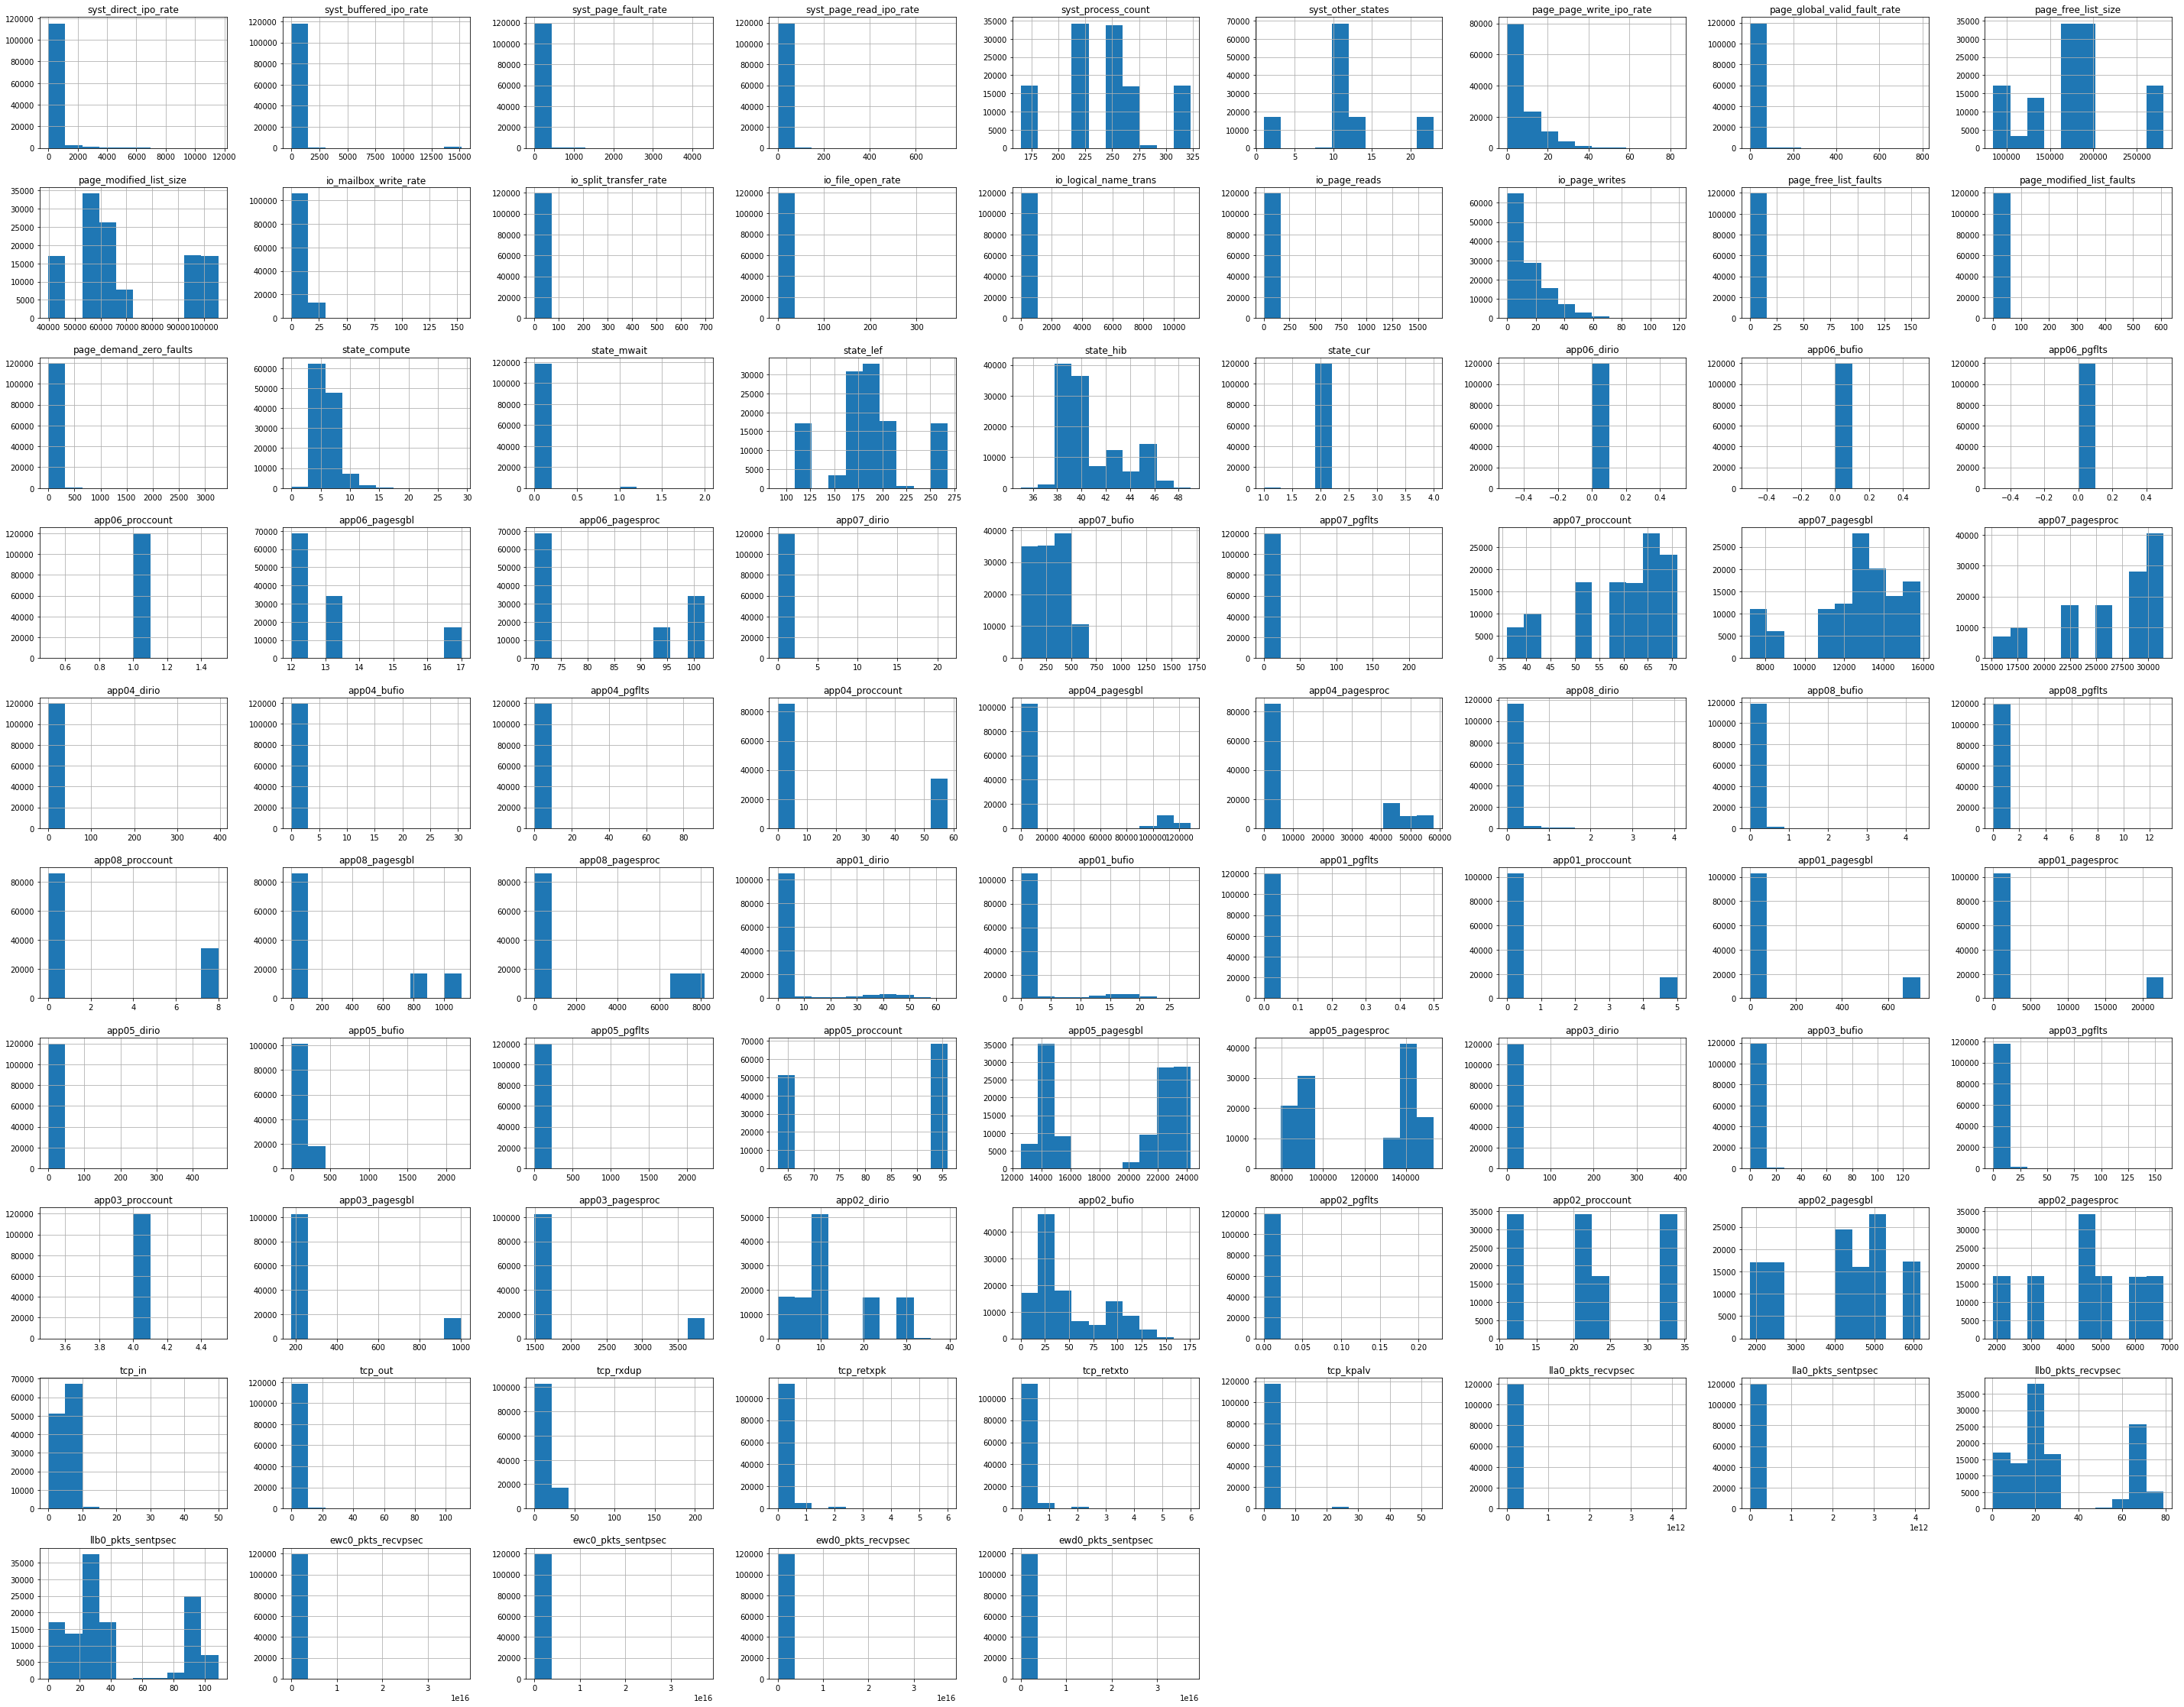

In [68]:
train.hist(figsize=(50,40), bins=10)
plt.show()

In [69]:
train.corr()

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,io_mailbox_write_rate,io_split_transfer_rate,io_file_open_rate,io_logical_name_trans,io_page_reads,io_page_writes,page_free_list_faults,page_modified_list_faults,page_demand_zero_faults,state_compute,state_mwait,state_lef,state_hib,state_cur,app06_dirio,app06_bufio,app06_pgflts,app06_proccount,app06_pagesgbl,app06_pagesproc,app07_dirio,app07_bufio,app07_pgflts,app07_proccount,app07_pagesgbl,app07_pagesproc,app04_dirio,app04_bufio,app04_pgflts,app04_proccount,app04_pagesgbl,app04_pagesproc,app08_dirio,app08_bufio,app08_pgflts,app08_proccount,app08_pagesgbl,app08_pagesproc,app01_dirio,app01_bufio,app01_pgflts,app01_proccount,app01_pagesgbl,app01_pagesproc,app05_dirio,app05_bufio,app05_pgflts,app05_proccount,app05_pagesgbl,app05_pagesproc,app03_dirio,app03_bufio,app03_pgflts,app03_proccount,app03_pagesgbl,app03_pagesproc,app02_dirio,app02_bufio,app02_pgflts,app02_proccount,app02_pagesgbl,app02_pagesproc,tcp_in,tcp_out,tcp_rxdup,tcp_retxpk,tcp_retxto,tcp_kpalv,lla0_pkts_recvpsec,lla0_pkts_sentpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec
syst_direct_ipo_rate,1.000000,0.034246,0.167055,0.168932,0.072361,0.009420,-0.119826,0.171535,-0.087268,0.114042,-0.052578,0.162201,0.254348,0.009651,0.168742,-0.135559,0.040951,0.137870,0.146992,0.033855,-0.016668,0.067520,0.090026,0.004581,NaN,NaN,NaN,NaN,-0.004547,0.039532,0.051977,-0.202835,0.000322,0.043205,0.035970,0.059100,-0.004753,0.030722,0.032026,0.101904,0.123328,0.110524,-0.037061,-0.036305,-0.001478,-0.028880,-0.029831,-0.029347,-0.035863,-0.035809,-0.000712,-0.010725,-0.010682,-0.010676,-0.018833,-0.132301,0.006869,-0.047588,-0.050481,-0.048218,0.013631,0.027409,0.028251,NaN,0.129042,0.128932,0.085217,0.025654,0.002508,0.031669,0.058520,0.045499,0.065809,0.074142,-0.018442,0.006233,0.006565,0.005111,-0.001289,-0.001099,0.103593,0.100387,0.006477,0.005923,-0.001498,-0.000101
syst_buffered_ipo_rate,0.034246,1.000000,0.034276,0.028839,0.145713,0.004016,0.038404,0.040738,-0.176282,0.241753,0.051080,0.002110,0.028712,0.064648,0.028461,0.034319,0.010222,0.034756,0.028047,0.037854,-0.012329,0.142118,0.134207,0.003844,NaN,NaN,NaN,NaN,-0.003742,0.081276,0.123396,0.037713,0.000041,0.092855,0.079296,0.127026,0.078483,0.065408,0.099830,0.215473,0.261134,0.232765,-0.024646,-0.024922,-0.000957,-0.069966,-0.069888,-0.070086,-0.012568,-0.012834,-0.001896,-0.041912,-0.041921,-0.041925,0.001503,-0.026284,0.004307,-0.074460,-0.084645,-0.080667,0.044762,0.112997,0.120764,NaN,0.273533,0.275349,0.184280,0.156370,0.024577,0.063166,0.116764,0.094813,0.015270,0.039414,-0.044662,0.078514,0.078017,-0.002909,0.000006,-0.000358,0.224844,0.217372,-0.001089,-0.001741,-0.001501,-0.001415
syst_page_fault_rate,0.167055,0.034276,1.000000,0.948283,0.023286,0.008499,-0.014547,0.970694,-0.029038,0.051810,0.056001,0.383948,0.581697,0.542381,0.936327,-0.014121,0.382565,0.902015,0.930791,0.005530,-0.005025,0.020371,0.043483,0.001347,NaN,NaN,NaN,NaN,-0.000892,0.022401,0.030958,-0.050262,0.033323,0.009446,0.003326,0.020924,0.051769,0.060871,0.039094,0.048623,0.073984,0.054851,-0.013036,-0.012681,0.001124,-0.013171,-0.013868,-0.013584,-0.010957,-0.010885,-0.000603,-0.003823,-0.003826,-0.003821,0.061706,-0.033103,0.153081,-0.040843,-0.044596,-0.043927,0.035950,0.088455,0.093991,NaN,0.075816,0.075401,0.033014,0.019734,0.007209,0.006339,0.019254,0.012193,0.276983,0.309050,-0.003002,0.031313,0.030551,-0.001550,-0.000416,-0.000535,0.046337,0.043735,-0.000695,-0.001291,-0.000627,-0.001112
syst_page_read_ipo_rate,0.168932,0.028839,0.948283,1.000000,0.020210,0.006847,-0.024978,0.983197,-0.024165,0.039114,0.013750,0.409516,0.557862,0.551075,0.998196,-0.026558,0.237227,0.810830,0.789349,0.010610,-0.004649,0.017569,0.036190,0.001240,NaN,NaN,NaN

### Preprocessing of Data

In [70]:
onehot_encoded = pd.get_dummies(train['m_id'])
print(type(onehot_encoded))

<class 'pandas.core.frame.DataFrame'>


In [71]:
onehot_encoded.head(3)

,a,b,c,d,e,f,g
0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0


In [72]:
new_col = onehot_encoded.columns
new_col

Index(['a', 'b', 'c', 'd', 'e', 'f', 'g'], dtype='object')

In [73]:
train[new_col] = onehot_encoded

In [74]:
train.head(3)

,m_id,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,io_mailbox_write_rate,io_split_transfer_rate,io_file_open_rate,io_logical_name_trans,io_page_reads,io_page_writes,page_free_list_faults,page_modified_list_faults,page_demand_zero_faults,state_compute,state_mwait,state_lef,state_hib,state_cur,app06_dirio,app06_bufio,app06_pgflts,app06_proccount,app06_pagesgbl,app06_pagesproc,app07_dirio,app07_bufio,app07_pgflts,app07_proccount,app07_pagesgbl,app07_pagesproc,app04_dirio,app04_bufio,app04_pgflts,app04_proccount,app04_pagesgbl,app04_pagesproc,app08_dirio,app08_bufio,app08_pgflts,app08_proccount,app08_pagesgbl,app08_pagesproc,app01_dirio,app01_bufio,app01_pgflts,app01_proccount,app01_pagesgbl,app01_pagesproc,app05_dirio,app05_bufio,app05_pgflts,app05_proccount,app05_pagesgbl,app05_pagesproc,app03_dirio,app03_bufio,app03_pgflts,app03_proccount,app03_pagesgbl,app03_pagesproc,app02_dirio,app02_bufio,app02_pgflts,app02_proccount,app02_pagesgbl,app02_pagesproc,tcp_in,tcp_out,tcp_rxdup,tcp_retxpk,tcp_retxto,tcp_kpalv,lla0_pkts_recvpsec,lla0_pkts_sentpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec,cpu_load,a,b,c,d,e,f,g
0,c,38.50,458.07,0.00,0.0,259,22,0.4,0.0,170323,60557,0.40,0.0,0.28,317.68,0.0,1.93,0.0,0.00,0.00,6,0,192,39,2,0,0,0,1,17,102,1.6,230.73,0.0,65,14037,31358,0.00,0.00,0.00,0,0,0,0.6,0.3,0.0,8,1084,7936,0.0,0.0,0.0,0,0,0,0.33,188.68,0.0,95,23458,141056,0.0,0.0,0.0,4,178,1538,6.00,18.97,0.0,34,5056,6275,5,5,35,0,0,0,415.483,479.983,15.367,20.667,281.383,245.533,278.767,277.300,medium,0,0,1,0,0,0,0
1,a,66.43,657.65,0.43,0.0,272,12,23.8,0.4,121776,102325,20.58,0.0,0.73,475.13,0.0,44.13,0.0,0.02,0.02,4,0,212,44,2,0,0,0,1,13,94,1.5,384.48,0.0,62,12880,29729,13.75,0.12,0.43,58,102879,57012,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.20,127.40,0.0,63,13982,87229,0.0,0.0,0.0,4,949,3832,22.57,99.57,0.0,24,4940,5153,4,4,0,0,0,0,526.533,554.550,67.300,88.650,438.583,401.633,436.000,366.183,medium,1,0,0,0,0,0,0
2,f,29.07,322.25,0.00,0.0,171,10,0.0,0.0,271435,44159,0.03,0.0,0.12,262.97,0.0,0.00,0.0,0.00,0.00,4,0,119,38,2,0,0,0,1,12,70,1.0,185.37,0.0,40,8076,16939,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.53,124.33,0.0,63,14355,88588,0.0,0.0,0.0,4,214,1556,0.00,0.00,0.0,11,1839,1894,5,5,0,0,0,0,337.967,314.067,0.667,0.017,230.333,230.050,220.200,240.333,low,0,0,0,0,0,1,0


#### NOT removing any predictor variable and hence storing the data as train_full_x.

In [75]:
train_full_x = train.drop(columns=['cpu_load'])

#### Removing predictor variables which are having correlation than 0.05 with target variable "cpu_load" and therefore, storing the new data frame as train_x.

In [76]:
train_x = train.drop(columns=['cpu_load','app06_dirio','app06_bufio','app06_pgflts','app06_proccount','syst_other_states','state_cur','app07_pgflts','app07_pgflts','app08_pgflts','app01_pgflts',
                             'app03_proccount','app03_bufio','ewd0_pkts_sentpsec','lla0_pkts_sentpsec'])

In [77]:
train_y = train['cpu_load']
train_y.replace(to_replace = ['low', 'medium', 'high'], value = [0,1,2], inplace = True)

In [78]:
train_full_x = train_full_x.drop(columns=['m_id'])
train_full_x.head(3)

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,syst_other_states,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,io_mailbox_write_rate,io_split_transfer_rate,io_file_open_rate,io_logical_name_trans,io_page_reads,io_page_writes,page_free_list_faults,page_modified_list_faults,page_demand_zero_faults,state_compute,state_mwait,state_lef,state_hib,state_cur,app06_dirio,app06_bufio,app06_pgflts,app06_proccount,app06_pagesgbl,app06_pagesproc,app07_dirio,app07_bufio,app07_pgflts,app07_proccount,app07_pagesgbl,app07_pagesproc,app04_dirio,app04_bufio,app04_pgflts,app04_proccount,app04_pagesgbl,app04_pagesproc,app08_dirio,app08_bufio,app08_pgflts,app08_proccount,app08_pagesgbl,app08_pagesproc,app01_dirio,app01_bufio,app01_pgflts,app01_proccount,app01_pagesgbl,app01_pagesproc,app05_dirio,app05_bufio,app05_pgflts,app05_proccount,app05_pagesgbl,app05_pagesproc,app03_dirio,app03_bufio,app03_pgflts,app03_proccount,app03_pagesgbl,app03_pagesproc,app02_dirio,app02_bufio,app02_pgflts,app02_proccount,app02_pagesgbl,app02_pagesproc,tcp_in,tcp_out,tcp_rxdup,tcp_retxpk,tcp_retxto,tcp_kpalv,lla0_pkts_recvpsec,lla0_pkts_sentpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,ewd0_pkts_sentpsec,a,b,c,d,e,f,g
0,38.50,458.07,0.00,0.0,259,22,0.4,0.0,170323,60557,0.40,0.0,0.28,317.68,0.0,1.93,0.0,0.00,0.00,6,0,192,39,2,0,0,0,1,17,102,1.6,230.73,0.0,65,14037,31358,0.00,0.00,0.00,0,0,0,0.6,0.3,0.0,8,1084,7936,0.0,0.0,0.0,0,0,0,0.33,188.68,0.0,95,23458,141056,0.0,0.0,0.0,4,178,1538,6.00,18.97,0.0,34,5056,6275,5,5,35,0,0,0,415.483,479.983,15.367,20.667,281.383,245.533,278.767,277.300,0,0,1,0,0,0,0
1,66.43,657.65,0.43,0.0,272,12,23.8,0.4,121776,102325,20.58,0.0,0.73,475.13,0.0,44.13,0.0,0.02,0.02,4,0,212,44,2,0,0,0,1,13,94,1.5,384.48,0.0,62,12880,29729,13.75,0.12,0.43,58,102879,57012,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.20,127.40,0.0,63,13982,87229,0.0,0.0,0.0,4,949,3832,22.57,99.57,0.0,24,4940,5153,4,4,0,0,0,0,526.533,554.550,67.300,88.650,438.583,401.633,436.000,366.183,1,0,0,0,0,0,0
2,29.07,322.25,0.00,0.0,171,10,0.0,0.0,271435,44159,0.03,0.0,0.12,262.97,0.0,0.00,0.0,0.00,0.00,4,0,119,38,2,0,0,0,1,12,70,1.0,185.37,0.0,40,8076,16939,0.00,0.00,0.00,0,0,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0,0,0,0.53,124.33,0.0,63,14355,88588,0.0,0.0,0.0,4,214,1556,0.00,0.00,0.0,11,1839,1894,5,5,0,0,0,0,337.967,314.067,0.667,0.017,230.333,230.050,220.200,240.333,0,0,0,0,0,1,0


In [79]:
train_x = train_x.drop(columns=['m_id'])
train_x.head(3)

,syst_direct_ipo_rate,syst_buffered_ipo_rate,syst_page_fault_rate,syst_page_read_ipo_rate,syst_process_count,page_page_write_ipo_rate,page_global_valid_fault_rate,page_free_list_size,page_modified_list_size,io_mailbox_write_rate,io_split_transfer_rate,io_file_open_rate,io_logical_name_trans,io_page_reads,io_page_writes,page_free_list_faults,page_modified_list_faults,page_demand_zero_faults,state_compute,state_mwait,state_lef,state_hib,app06_pagesgbl,app06_pagesproc,app07_dirio,app07_bufio,app07_proccount,app07_pagesgbl,app07_pagesproc,app04_dirio,app04_bufio,app04_pgflts,app04_proccount,app04_pagesgbl,app04_pagesproc,app08_dirio,app08_bufio,app08_proccount,app08_pagesgbl,app08_pagesproc,app01_dirio,app01_bufio,app01_proccount,app01_pagesgbl,app01_pagesproc,app05_dirio,app05_bufio,app05_pgflts,app05_proccount,app05_pagesgbl,app05_pagesproc,app03_dirio,app03_pgflts,app03_pagesgbl,app03_pagesproc,app02_dirio,app02_bufio,app02_pgflts,app02_proccount,app02_pagesgbl,app02_pagesproc,tcp_in,tcp_out,tcp_rxdup,tcp_retxpk,tcp_retxto,tcp_kpalv,lla0_pkts_recvpsec,llb0_pkts_recvpsec,llb0_pkts_sentpsec,ewc0_pkts_recvpsec,ewc0_pkts_sentpsec,ewd0_pkts_recvpsec,a,b,c,d,e,f,g
0,38.50,458.07,0.00,0.0,259,0.4,0.0,170323,60557,0.40,0.0,0.28,317.68,0.0,1.93,0.0,0.00,0.00,6,0,192,39,17,102,1.6,230.73,65,14037,31358,0.00,0.00,0.00,0,0,0,0.6,0.3,8,1084,7936,0.0,0.0,0,0,0,0.33,188.68,0.0,95,23458,141056,0.0,0.0,178,1538,6.00,18.97,0.0,34,5056,6275,5,5,35,0,0,0,415.483,15.367,20.667,281.383,245.533,278.767,0,0,1,0,0,0,0
1,66.43,657.65,0.43,0.0,272,23.8,0.4,121776,102325,20.58,0.0,0.73,475.13,0.0,44.13,0.0,0.02,0.02,4,0,212,44,13,94,1.5,384.48,62,12880,29729,13.75,0.12,0.43,58,102879,57012,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.20,127.40,0.0,63,13982,87229,0.0,0.0,949,3832,22.57,99.57,0.0,24,4940,5153,4,4,0,0,0,0,526.533,67.300,88.650,438.583,401.633,436.000,1,0,0,0,0,0,0
2,29.07,322.25,0.00,0.0,171,0.0,0.0,271435,44159,0.03,0.0,0.12,262.97,0.0,0.00,0.0,0.00,0.00,4,0,119,38,12,70,1.0,185.37,40,8076,16939,0.00,0.00,0.00,0,0,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0.53,124.33,0.0,63,14355,88588,0.0,0.0,214,1556,0.00,0.00,0.0,11,1839,1894,5,5,0,0,0,0,337.967,0.667,0.017,230.333,230.050,220.200,0,0,0,0,0,1,0


In [80]:
train_y.head(3)

0    1
1    1
2    0
Name: cpu_load, dtype: int64

In [81]:
# splitting the full data set
trainX, testvalX, trainY, testvalY = train_test_split(train_full_x, train_y, test_size=0.1, random_state=None)
valX, testX, valY, testY = train_test_split(testvalX, testvalY, test_size = 0.5, random_state=None)

# Decision Tree Classifier

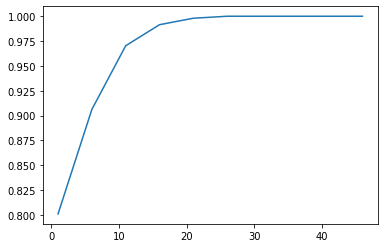

In [82]:
depths = np.arange(1,50,5)
accuracy = []
for depth in depths:
  dt = DecisionTreeClassifier(max_depth=depth)
  dt.fit(valX, valY)
  valY_ = dt.predict(valX)
  accuracy.append(accuracy_score(valY, valY_))
#(print(len(depths), len(accuracy)))
plt.plot(depths, accuracy)
plt.show()

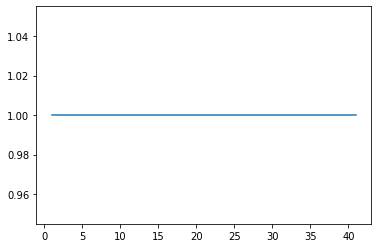

In [83]:
# max_depth = 20 from above hyperparameter tuning

features = np.arange(1,50,10)
accuracy = []
for feature in features:
  dt = DecisionTreeClassifier(max_features=feature)
  dt.fit(valX, valY)
  valY_ = dt.predict(valX)
  accuracy.append(accuracy_score(valY, valY_))
#(print(len(features), len(accuracy)))
plt.plot(features, accuracy)
plt.show()

In [85]:
# max_depth = 20 from above hyperparameter tuning
# num of features is not an important factor

dt = DecisionTreeClassifier(max_depth=20, criterion='entropy')
dt.fit(trainX, trainY)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Random Forest Classifier as an instantiation of Bagging Classifier where T = Decision Tree Classifier

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 1 for this parallel run (total 1)...
Building estimator 1 of 6 for this parallel run (total 6)...
Building estimator 2 of 6 for this parallel run (total 6)...
Building estimator 3 of 6 for this parallel run (total 6)...
Building estimator 4 of 6 for this parallel run (total 6)...
Building estimator 5 of 6 for this parallel run (total 6)...
Building estimator 6 of 6 for this parallel run (total 6)...
Building estimator 1 of 11 for this parallel run (total 11)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 2 of 11 for this parallel run (total 11)...
Building estimator 3 of 11 for this parallel run (total 11)...
Building estimator 4 of 11 for this parallel run (total 11)...
Building estimator 5 of 11 for this parallel run (total 11)...
Building estimator 6 of 11 for this parallel run (total 11)...
Building estimator 7 of 11 for this parallel run (total 11)...
Building estimator 8 of 11 for this parallel run (total 11)...
Building estimator 9 of 11 for this parallel run (total 11)...
Building estimator 10 of 11 for this parallel run (total 11)...
Building estimator 11 of 11 for this parallel run (total 11)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 16 for this parallel run (total 16)...
Building estimator 2 of 16 for this parallel run (total 16)...
Building estimator 3 of 16 for this parallel run (total 16)...
Building estimator 4 of 16 for this parallel run (total 16)...
Building estimator 5 of 16 for this parallel run (total 16)...
Building estimator 6 of 16 for this parallel run (total 16)...
Building estimator 7 of 16 for this parallel run (total 16)...
Building estimator 8 of 16 for this parallel run (total 16)...
Building estimator 9 of 16 for this parallel run (total 16)...
Building estimator 10 of 16 for this parallel run (total 16)...
Building estimator 11 of 16 for this parallel run (total 16)...
Building estimator 12 of 16 for this parallel run (total 16)...
Building estimator 13 of 16 for this parallel run (total 16)...
Building estimator 14 of 16 for this parallel run (total 16)...
Building estimator 15 of 16 for this parallel run (total 16)...
Building estimator 16 of 16 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 21 for this parallel run (total 21)...
Building estimator 2 of 21 for this parallel run (total 21)...
Building estimator 3 of 21 for this parallel run (total 21)...
Building estimator 4 of 21 for this parallel run (total 21)...
Building estimator 5 of 21 for this parallel run (total 21)...
Building estimator 6 of 21 for this parallel run (total 21)...
Building estimator 7 of 21 for this parallel run (total 21)...
Building estimator 8 of 21 for this parallel run (total 21)...
Building estimator 9 of 21 for this parallel run (total 21)...
Building estimator 10 of 21 for this parallel run (total 21)...
Building estimator 11 of 21 for this parallel run (total 21)...
Building estimator 12 of 21 for this parallel run (total 21)...
Building estimator 13 of 21 for this parallel run (total 21)...
Building estimator 14 of 21 for this parallel run (total 21)...
Building estimator 15 of 21 for this parallel run (total 21)...
Building estimator 16 of 21 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


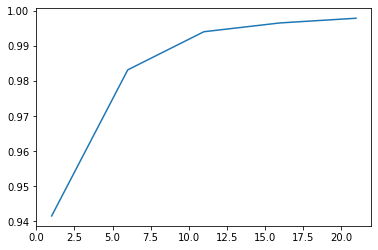

In [86]:
nest = np.arange(1,25,5)
accuracy = []
for n in nest:
  bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15, criterion='entropy'),n_estimators=n, verbose=2)
  bc.fit(valX, valY)
  valY_ = bc.predict(valX)
  accuracy.append(accuracy_score(valY, valY_))
plt.plot(nest, accuracy)
plt.show()

In [87]:
# creating the same bagging classifier with n_estimators=20

bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15, criterion='entropy'), n_estimators=20, verbose=2)
bc.fit(trainX, trainY)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 20 for this parallel run (total 20)...
Building estimator 2 of 20 for this parallel run (total 20)...
Building estimator 3 of 20 for this parallel run (total 20)...
Building estimator 4 of 20 for this parallel run (total 20)...
Building estimator 5 of 20 for this parallel run (total 20)...
Building estimator 6 of 20 for this parallel run (total 20)...
Building estimator 7 of 20 for this parallel run (total 20)...
Building estimator 8 of 20 for this parallel run (total 20)...
Building estimator 9 of 20 for this parallel run (total 20)...
Building estimator 10 of 20 for this parallel run (total 20)...
Building estimator 11 of 20 for this parallel run (total 20)...
Building estimator 12 of 20 for this parallel run (total 20)...
Building estimator 13 of 20 for this parallel run (total 20)...
Building estimator 14 of 20 for this parallel run (total 20)...
Building estimator 15 of 20 for this parallel run (total 20)...
Building estimator 16 of 20 for this parallel run

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=15,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,

# Prediction of the Decision tree and Random forest classifiers on trainY data.

In [88]:
trainY_dt = dt.predict_proba(trainX)
print("Log Loss = ", log_loss(trainY, trainY_dt))
print("F1-score = ", f1_score(trainY, np.argmax(trainY_dt, axis=1), average='weighted'))
print("Precision = ", precision_score(trainY, np.argmax(trainY_dt, axis=1), average='weighted'))
print("Recall = ", recall_score(trainY, np.argmax(trainY_dt, axis=1), average='weighted'))

Log Loss =  0.028458455803449103
F1-score =  0.9862629835258961
Precision =  0.986331184415894
Recall =  0.986308358765526


In [89]:
trainY_bc = bc.predict_proba(trainX)
print("Log Loss = ", log_loss(trainY, trainY_bc))
print("F1-score = ", f1_score(trainY, np.argmax(trainY_bc, axis=1), average='weighted'))
print("Precision = ", precision_score(trainY, np.argmax(trainY_bc, axis=1), average='weighted'))
print("Recall = ", recall_score(trainY, np.argmax(trainY_bc, axis=1), average='weighted'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Log Loss =  0.09769649352435113
F1-score =  0.9703896186763079
Precision =  0.9709148628738
Recall =  0.9706501674350435


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


In [97]:
testY_dt = dt.predict_proba(testX)
print("Log Loss = ", log_loss(testY, testY_dt))
print("F1-score = ", f1_score(testY, np.argmax(testY_dt, axis=1), average='weighted'))
print("Precision = ", precision_score(testY, np.argmax(testY_dt, axis=1), average='weighted'))
print("Recall = ", recall_score(testY, np.argmax(testY_dt, axis=1), average='weighted'))
print(confusion_matrix(testY, np.argmax(testY_dt, axis=1)))
print("Accuracy = ", accuracy_score(testY, np.argmax(testY_dt, axis=1)))

Log Loss =  3.6007024876747327
F1-score =  0.876878345169595
Precision =  0.8766115468794066
Recall =  0.8774624373956594
[[1966  184    2]
 [ 183 2740  155]
 [   2  208  550]]
Accuracy =  0.8774624373956594


In [99]:
testY_bc = bc.predict_proba(testX)
print("Log Loss = ", log_loss(testY, testY_bc))
print("F1-score = ", f1_score(testY, np.argmax(testY_bc, axis=1), average='weighted'))
print("Precision = ", precision_score(testY, np.argmax(testY_bc, axis=1), average='weighted'))
print("Recall = ", recall_score(testY, np.argmax(testY_bc, axis=1), average='weighted'))
print(confusion_matrix(testY, np.argmax(testY_bc, axis=1)))
print("Accuracy = ", accuracy_score(testY, np.argmax(testY_bc, axis=1)))

Log Loss =  0.23642663629576116
F1-score =  0.9038930825732108
Precision =  0.9047046493281057
Recall =  0.9048414023372288
[[1990  161    1]
 [ 118 2869   91]
 [   1  198  561]]
Accuracy =  0.9048414023372288


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


# Conclusion

### Hence, Bagging Classifier with Decision Tree as a base estimator is a better model than standalone Decision Tree and Random Forest Classifiers as evident from the F score values comparison.

#F1-score (Bagging) = 0.90
#F1-score (Decision Tree) = 0.87